In [5]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)


import gym
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.n_step_tree_backup import nStepTreeBackupAgent
from source.utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


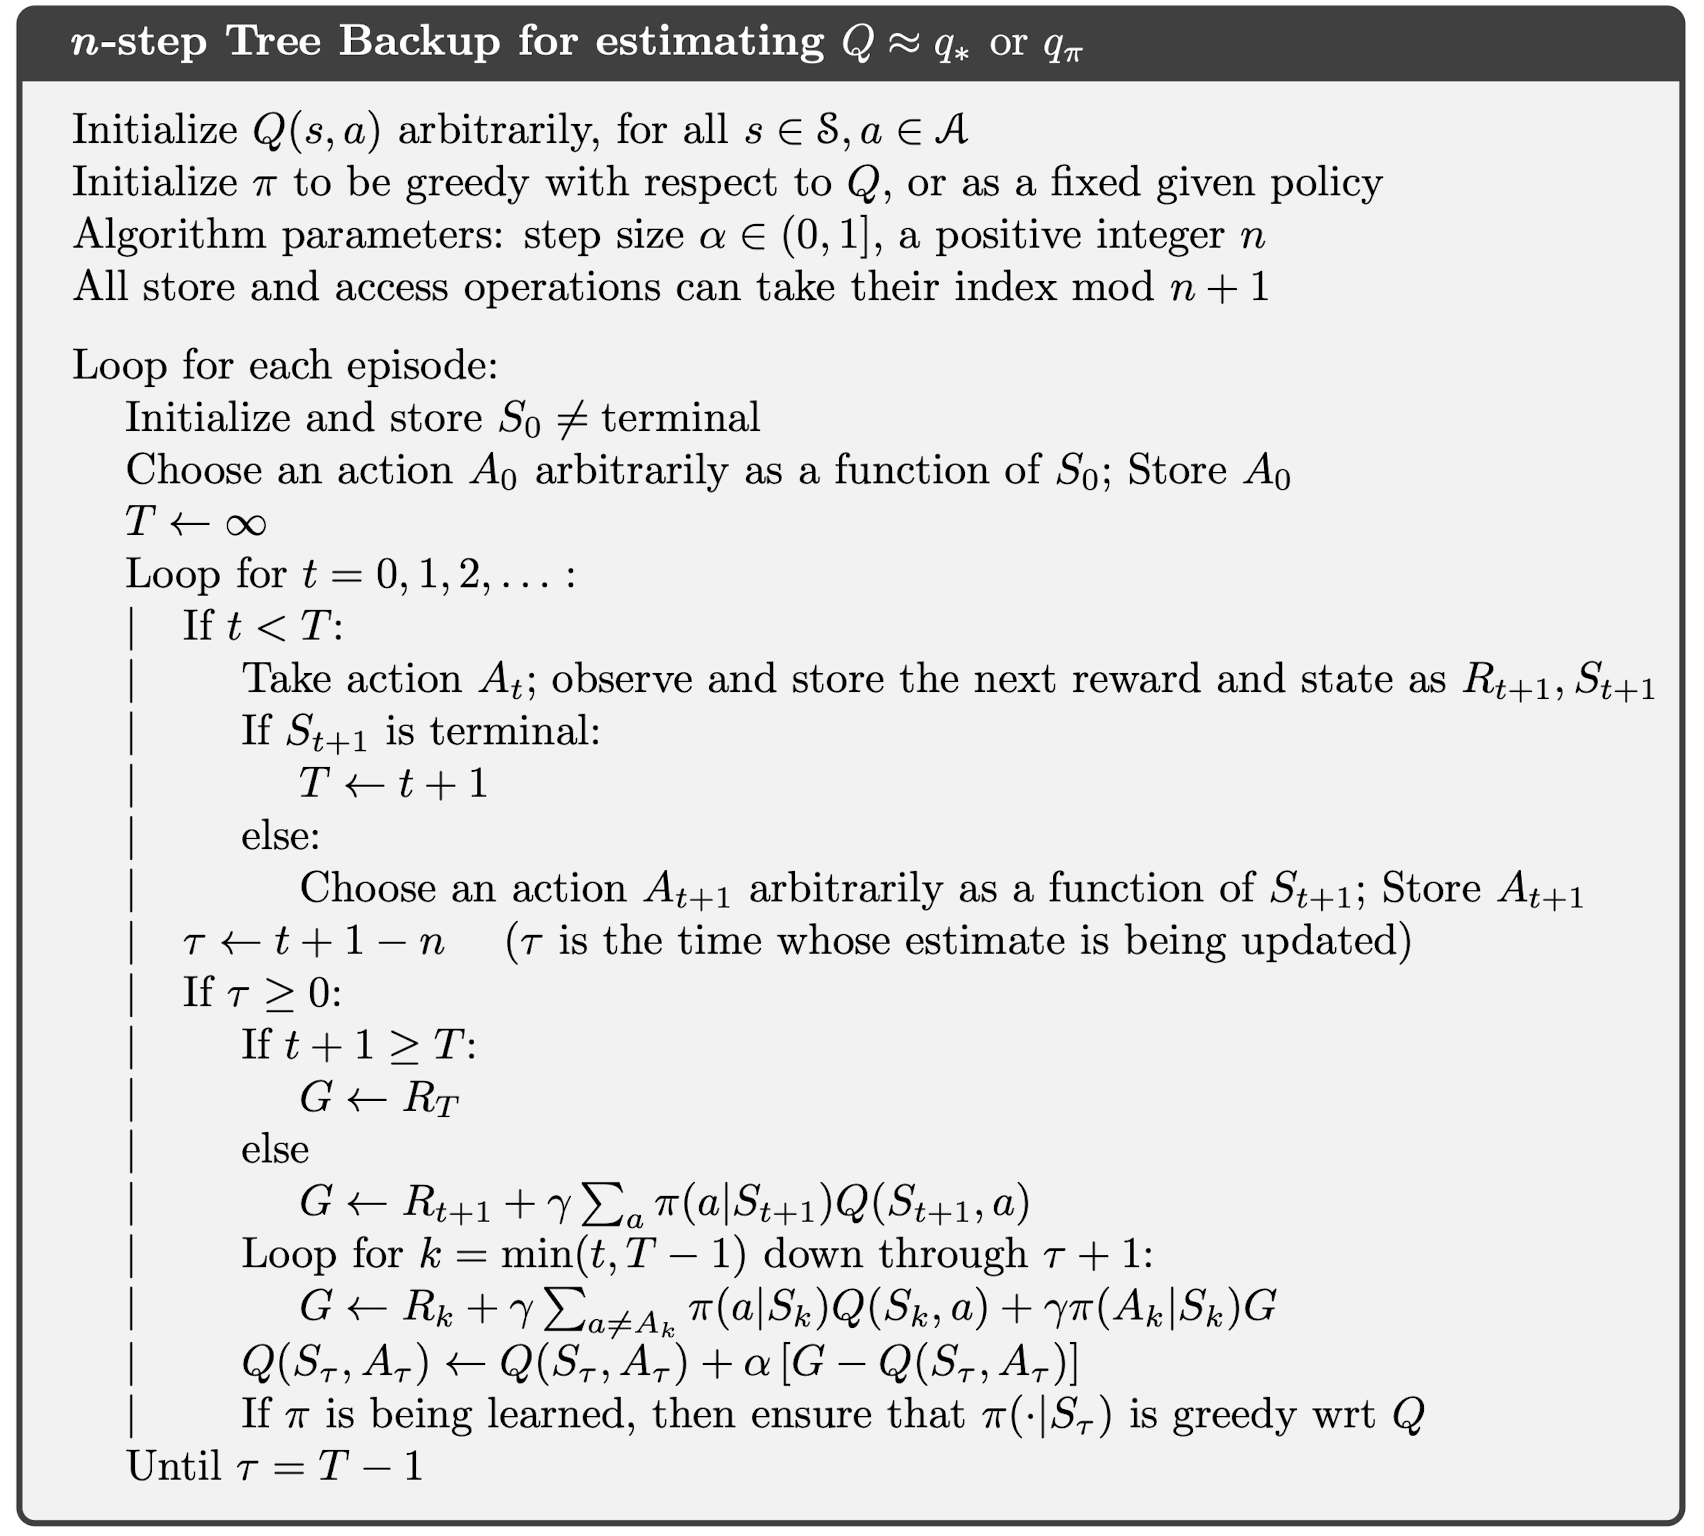

step: 1000, epsilon: 0.65230169730996, total reward: 126.0, avarge success rate: 0.126, avarage reward per step: 0.008196024459536868
step: 2000, epsilon: 0.4727750047927273, total reward: 183.0, avarge success rate: 0.057, avarage reward per step: 0.00568219600477665
step: 3000, epsilon: 0.3426577089689116, total reward: 242.0, avarge success rate: 0.059, avarage reward per step: 0.0060056624372229065
step: 4000, epsilon: 0.2483513390630704, total reward: 317.0, avarge success rate: 0.075, avarage reward per step: 0.006964741728358434
step: 5000, epsilon: 0.18000000000004682, total reward: 440.0, avarge success rate: 0.122, avarage reward per step: 0.008928150598658353
step: 6000, epsilon: 0.13046033946202593, total reward: 829.0, avarge success rate: 0.389, avarage reward per step: 0.018793567661280073
step: 7000, epsilon: 0.09455500095857006, total reward: 1232.0, avarge success rate: 0.403, avarage reward per step: 0.02078720786200801
step: 8000, epsilon: 0.06853154179380015, total

Moviepy - Done !
Moviepy - video ready ../../video/n_step_td_on_policy.mp4


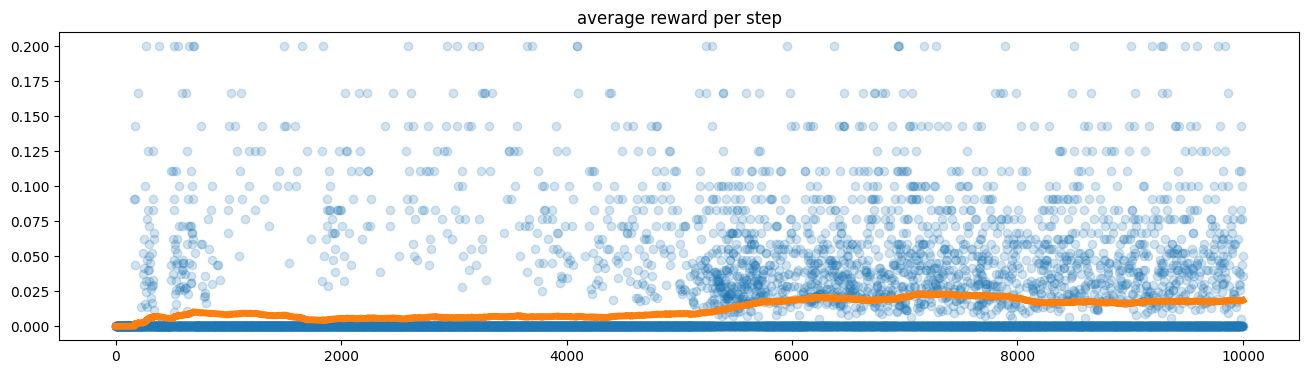

: 

In [8]:
# Policy Eval
# Params
max_episode = 10000
video_path = os.path.join(ROOT, "video/n_step_td_on_policy.mp4")
random_seed = 101

# Initialize
history = []
total_reward = 0
report_interval = max_episode // 10
# set random seeds
rng = np.random.default_rng(random_seed)
np.random.seed(random_seed)
# epsilon decay
epsilon_schedule = create_decay_schedule(max_episode)
lr_schedule = create_decay_schedule(max_episode)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4",
               is_slippery=True, render_mode='rgb_array')
env.np_random = rng

# Create Agent
agent = nStepTreeBackupAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    discount_rate=0.9,
    epsilon=0.2,
    learning_rate=0.5,
    n=30
)
# Start Learning
for i in range(max_episode):
    reward, steps = agent.play_episode(env, 'behavior', epsilon=epsilon_schedule[i])
    history.append(reward / steps)
    total_reward += reward
    if i % report_interval == 0 and i != 0:
        print(
            f"step: {i}, epsilon: {epsilon_schedule[i]}, total reward: {total_reward}, avarge success rate: {np.sum([x > 0 for x in history[-report_interval:-1]])/report_interval}, avarage reward per step: {np.mean(history[-report_interval:-1])}")
print(f"\nrewarding episodes: {total_reward}")

# play last episode with video recording
agent.play_episode(env, 'target', video_path=video_path)

plot_history(history)
html=render_mp4(video_path)
HTML(html)


[[b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'DOWN']
 [b'DOWN' b'UP' b'UP' b'RIGH' b'UP' b'DOWN' b'LEFT' b'DOWN']
 [b'RIGH' b'UP' b'LEFT' b'DOWN' b'RIGH' b'RIGH' b'DOWN' b'DOWN']
 [b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'UP' b'UP' b'DOWN' b'DOWN']
 [b'UP' b'LEFT' b'UP' b'LEFT' b'UP' b'RIGH' b'RIGH' b'DOWN']
 [b'UP' b'DOWN' b'LEFT' b'RIGH' b'DOWN' b'UP' b'DOWN' b'DOWN']
 [b'DOWN' b'UP' b'DOWN' b'LEFT' b'DOWN' b'UP' b'LEFT' b'DOWN']
 [b'DOWN' b'DOWN' b'UP' b'RIGH' b'RIGH' b'LEFT' b'UP' b'RIGH']]


Text(0.5, 1.0, 'state_values')

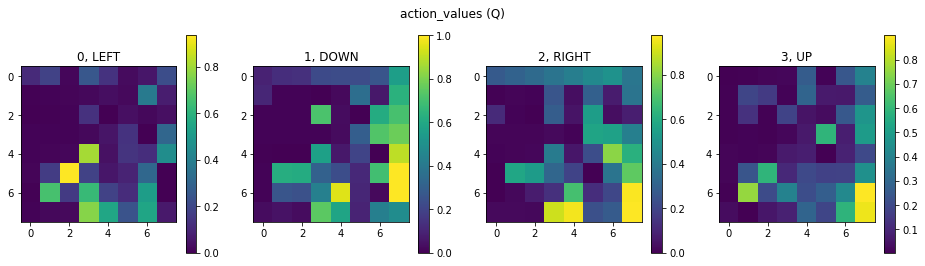

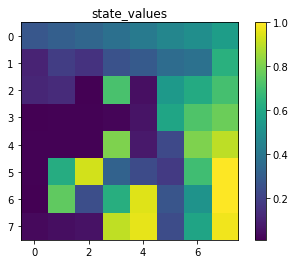

In [ ]:
# Plot the action values.
# cliff walking
#shape = (4,12,4)
# frozen lake
## small
#shape = (4,4,4)
## large
shape = (8,8,4)
direction = {
  0:"LEFT",
  1:"DOWN",
  2:"RIGHT",
  3:"UP"
}
actions = np.argmax(agent._target_policy, axis=1)
actions = actions.reshape(shape[:2])
named_actions = np.chararray(actions.shape, itemsize=4)
map = [[""] * shape[1]] * shape[0]
for idx, val in np.ndenumerate(actions):
  named_actions[idx] = direction[val]
  #map[idx[0]][idx[1]] = direction[val]
print(named_actions)

action_values = agent._Q.reshape(shape)
num_actions = action_values.shape[-1]
plt.figure(2, figsize=(16,4))
plt.suptitle("action_values (Q)")
for i in range(num_actions):
  plt.subplot(1, num_actions,i+1)
  plt.title(f"{i}, {direction[i]}")
  plt.imshow(action_values[:,:,i])
  plt.colorbar(orientation='vertical')
  #print(action_values[:,:,i])


plt.figure(3)
state_values = get_state_values_from_action_values(agent._Q, agent._target_policy)
plt.imshow(state_values.reshape(shape[:2]))
plt.colorbar(orientation='vertical')
plt.title("state_values")


# Summary

## Temporal Difference on policy learning 
Temporal difference combines Monte Carlo with dynamic programming.
```
V(s) = V(s) + learning_rate * (reward + discount_rate * V(s') - V(s))
```
The last part is also called TD-error:
```
td_error = (reward + discount_rate * V(s') - V(s))
```

### Sarsa
Sarsa requires `(state, action, reward, next_state, next_action)` to update action_values `_Q` and use that to create a epsilon-greedy policy `_policy`.

What makes it on-policy learning is that fact that `next_action` is both 
1. the action the agent is taking  -> behavior policy
2. the action the agent is using to update the action values `_Q` (policy evluation) -> target policy

The conflict is that 1 requires exploration to learn from unexplored environment. But 2 is affected by such exploration (because next action will not always be the optimal one, affecting the value of `_Q`). 


